In [1]:
#Importing Keras packages
from __future__ import print_function
import os
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras import optimizers
from tensorflow.keras.preprocessing import image
from keras.layers.advanced_activations import ELU, LeakyReLU, PReLU, Softmax, ReLU
from keras.regularizers import l2
from tensorflow.keras import initializers
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

Using TensorFlow backend.


In [2]:
#Ensuring the model is built on the existing GPU
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1
physical_devices------------- 1


In [3]:
#Data Importing, Pre-processing and Inspection
my_data_dir = 'C:\\Users\\Admin\\Desktop\\Research\\Datasets Used\\Malaria\\cell_images'

In [4]:
test_path = my_data_dir+'\\test\\'
train_path = my_data_dir+'\\train\\'

In [5]:
os.listdir(my_data_dir)
os.listdir(test_path)
os.listdir(train_path)
os.listdir(train_path+'\\infected')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

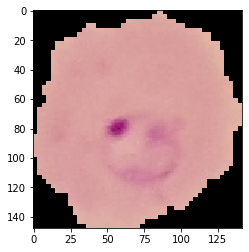

In [6]:
para_cell = train_path+'\\infected'+'\\C100P61ThinF_IMG_20150918_144104_cell_162.png'
para_img= imread(para_cell)
plt.imshow(para_img)

In [7]:
para_img.shape

(148, 142, 3)

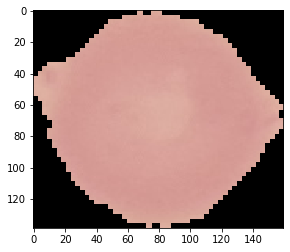

In [8]:
unifected_cell_path = train_path+'\\uninfected\\'+os.listdir(train_path+'\\uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

In [9]:
len(os.listdir(train_path+'\\infected'))

12480

In [10]:
len(os.listdir(train_path+'\\uninfected'))

12480

In [11]:
unifected_cell.shape

(139, 160, 3)

In [12]:
para_img.shape

(148, 142, 3)

In [13]:
image_shape = (128,128,3)
input_shape = image_shape

In [14]:
#Data Augmentation setup
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rotation_range = 15, # rotate the image 20 degrees
                               width_shift_range = 0.20, # Shift the pic width by a max of 5%
                               height_shift_range = 0.20, # Shift the pic height by a max of 5%
                               rescale = 1/255, # Rescale the image by normalzing it.
                               shear_range = 0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range = 0.2, # Zoom in by 10% max
                               horizontal_flip = True, # Allo horizontal flipping
                               )
image_gen.flow_from_directory(train_path)
image_gen.flow_from_directory(test_path)

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [15]:
from keras.applications import VGG16

img_rows = 128
img_cols = 128 

#Loads the VGG16 model without the top or FC layers
vgg16 = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

for layer in vgg16.layers:
    layer.trainable = False
    
for (i,layer) in enumerate(vgg16.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [16]:
#Building ontop of the freezed layers
def addTopModel(bottom_model, num_classes, D = 512):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "elu")(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(1, activation = "sigmoid")(top_model)
    return top_model

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 2

FC_Head = addTopModel(vgg16, num_classes)

model = Model(inputs = vgg16.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [18]:
#Setting up training
model.compile(loss = 'binary_crossentropy',
              optimizer = keras.optimizers.Adam(lr = 0.001),
              metrics = ['accuracy'])

batch_size = 32

train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size = image_shape[:2],
                                               color_mode = 'rgb',
                                               batch_size = batch_size,
                                               class_mode = 'binary')

test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size = image_shape[:2],
                                               color_mode = 'rgb',
                                               batch_size = batch_size,
                                               class_mode = 'binary',shuffle=False)

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [19]:
#Model testing
results = model.fit_generator(train_image_gen, epochs = 10, validation_data = test_image_gen)  

#Saving model weights
from tensorflow.keras.models import load_model
model.save('C:\\Users\\Admin\\Desktop\\Research\\Results\\VGGNet Results\\Weights\\Malaria_VGGNet_ELU_Adam.h5')

Epoch 1/10
780/780 [==============================] - 86s 111ms/step - loss: 0.4487 - accuracy: 0.8310 - val_loss: 0.1134 - val_accuracy: 0.8912
Epoch 2/10
780/780 [==============================] - 83s 107ms/step - loss: 0.3046 - accuracy: 0.8780 - val_loss: 0.1230 - val_accuracy: 0.8862
Epoch 3/10
780/780 [==============================] - 83s 107ms/step - loss: 0.2741 - accuracy: 0.8907 - val_loss: 0.2506 - val_accuracy: 0.9054
Epoch 4/10
780/780 [==============================] - 83s 106ms/step - loss: 0.2666 - accuracy: 0.8961 - val_loss: 0.2480 - val_accuracy: 0.9077
Epoch 5/10
780/780 [==============================] - 83s 107ms/step - loss: 0.2698 - accuracy: 0.8957 - val_loss: 0.4037 - val_accuracy: 0.8992
Epoch 6/10
780/780 [==============================] - 83s 107ms/step - loss: 0.2653 - accuracy: 0.8953 - val_loss: 0.1918 - val_accuracy: 0.8985
Epoch 7/10
780/780 [==============================] - 83s 106ms/step - loss: 0.2622 - accuracy: 0.8977 - val_loss: 0.3529 - val_ac

In [20]:
#Model evaluation
model.evaluate_generator(test_image_gen)

[0.47111570835113525, 0.9049999713897705]

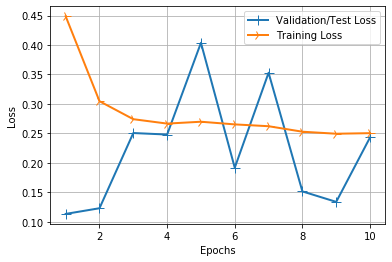

In [21]:
history_dict = results.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')
plt.setp(line1, linewidth = 2.0, marker = '+', markersize = 10.0)
plt.setp(line2, linewidth = 2.0, marker = '4', markersize = 10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import classification_report,confusion_matrix
pred_probabilities = model.predict_generator(test_image_gen)
predictions = pred_probabilities > 0.5
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1300
           1       0.89      0.92      0.91      1300

    accuracy                           0.90      2600
   macro avg       0.90      0.90      0.90      2600
weighted avg       0.90      0.90      0.90      2600



In [23]:
#Model prediction
para_cell
my_image = image.load_img(para_cell, target_size = image_shape)
my_image
my_image = image.img_to_array(my_image)
my_image.shape

(128, 128, 3)

In [24]:
my_image = np.expand_dims(my_image, axis = 0)
my_image.shape

(1, 128, 128, 3)

In [25]:
train_image_gen.class_indices

{'infected': 0, 'uninfected': 1}

In [26]:
model.predict(my_image)

array([[0.]], dtype=float32)